In [1]:
![ ! -f "pip_installed" ] && pip install -q tensorflow-datasets==4.4.0 openTSNE && \
cp /content/drive/MyDrive/TeamSemiSuperCV/Active_Learn/preprocess.py . && \
unzip -qq /content/drive/MyDrive/TeamSemiSuperCV/Wing/xray_reborn.zip -d /root/tensorflow_datasets && \
mkdir /content/model && \
cp -R /content/drive/MyDrive/TeamSemiSuperCV/Stage3_Model/random_2pc/saved_model_keras/37000/* /content/model && \
!touch pip_installed

     |████████████████████████████████| 4.0 MB 8.3 MB/s 
     |████████████████████████████████| 2.4 MB 32.3 MB/s 
/bin/bash: !touch: command not found


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from importlib import reload
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, GlobalMaxPooling2D, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model

# openTSNE supports separate fit() and transform()
from openTSNE import TSNE

In [3]:
SSL_MODEL = True
FSL_MODEL = False

if SSL_MODEL:
  IMG_SIZE = (224, 224, 3)
elif FSL_MODEL:
  IMG_SIZE = (256, 256, 3)

NUM_FEATS = 2000
NPZ_FILE = '/content/drive/MyDrive/TeamSemiSuperCV/Wing/SSL_ResNet50_XrayReborn_tSNE_Feats.npz'
# NPZ_FILE = './tsne_feats.npz'

## Extract and Save Features Set from model's final dense layer

In [4]:
def img_preprocess(imgs):
  if SSL_MODEL:
    imgs = tf.image.convert_image_dtype(imgs, dtype=tf.float32)
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bicubic')
    imgs = tf.clip_by_value(imgs, 0.0, 1.0)
  elif FSL_MODEL:
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bicubic')
    imgs = tf.cast(imgs, tf.uint8)
  else:
    raise Exception
  return imgs

In [5]:
def model_fsl_preprocess(x):
    x = Rescaling(1/255)(x)
    return x

def make_fsl_model(input_shape):
    base_model = ResNet50(include_top=False, pooling=None, weights=None,
                          input_shape=input_shape)
    
    inputs = Input(shape=input_shape)
    x = model_fsl_preprocess(inputs)
    x = base_model(x)
    x = Lambda(lambda x: x, name='lambda_1')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
if FSL_MODEL:
  model = make_fsl_model(IMG_SIZE)
  # model.load_weights('/content/drive/MyDrive/TeamSemiSuperCV/Wing/FSL_Benchmarks/FSL_ResNet50_XrayReborn.h5')
  model.load_weights('./FSL_ResNet50_XrayReborn.h5')
elif SSL_MODEL: 
  model = tf.keras.models.load_model('model')
  
model.trainable = False
model.build(IMG_SIZE)
model.summary()

In [7]:
model_d = Model(inputs=model.input, outputs=model.get_layer('dense').output)
# model_d.summary()

In [8]:
# model_g = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
# model_g.summary()

In [9]:
ds = tfds.load('xray_reborn')
ds_train = ds['train']
ds_valid = ds['validation']
ds_test = ds['test']

In [10]:
def label_preprocess(y):
  if FSL_MODEL:
    return y
  if SSL_MODEL:
    return tf.one_hot(y, 2)

ds_train_xy = ds_train.map(lambda d: (d['image'], d['label']))
ds_train_xy = ds_train_xy.map(lambda x, y: (img_preprocess(x), label_preprocess(y)))

ds_valid_xy = ds_valid.map(lambda d: (d['image'], d['label']))
ds_valid_xy = ds_valid_xy.map(lambda x, y: (img_preprocess(x), label_preprocess(y)))

ds_test_xy = ds_test.map(lambda d: (d['image'], d['label']))
ds_test_xy = ds_test_xy.map(lambda x, y: (img_preprocess(x), label_preprocess(y)))

ds_train_xy.element_spec, ds_valid_xy.element_spec, ds_test_xy.element_spec

((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(2,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(2,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(2,), dtype=tf.float32, name=None)))

In [11]:
# Extract Features from 'dense' layer for t-SNE transform
feats = []
labels = []

for batch_x, batch_y in ds_train_xy.batch(512):
  print(batch_x.shape, batch_y.shape)
  feats.append(model_d(batch_x, training=False))
  labels.append(np.argmax(batch_y, axis=1))

feats = np.concatenate(feats)
labels = np.concatenate(labels)
feats.shape, labels.shape

(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(512, 224, 224, 3) (512, 2)
(100, 224, 224, 3) (100, 2)


((4708, 64), (4708,))

In [12]:
# Sample a reduced set of features
SAMP_SEED = 15
feats_idxs = np.arange(len(feats))
np.random.seed(SAMP_SEED)
np.random.shuffle(feats_idxs)
feats_sm = np.empty((NUM_FEATS, *feats.shape[1:]), dtype=np.float32)
labels_sm = np.empty((NUM_FEATS,), dtype=np.int32)
for i, idx in enumerate(feats_idxs[:NUM_FEATS]):
  feats_sm[i] = feats[idx]
  labels_sm[i] = labels[idx]

In [13]:
np.savez(NPZ_FILE, feats=feats_sm, labels=labels_sm)

## Load Saved Features and Generate t-SNE plots

In [14]:
npz = np.load(NPZ_FILE)
print(npz['feats'].shape, npz['labels'].shape)

feats_sm = npz['feats']
print(feats_sm[0][:5])

labels_sm = npz['labels']
print(labels_sm[:50][:20])

(2000, 64) (2000,)
[0.0758328  0.         0.19560687 0.26982424 0.38840264]
[1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0]


In [16]:
colormap = np.array(['r', 'b', 'k'])

(2000, 2)
CPU times: user 17.1 s, sys: 448 ms, total: 17.5 s
Wall time: 9.75 s


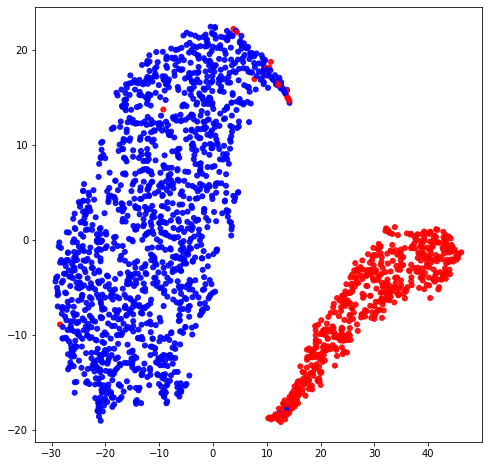

In [17]:
%%time
tsne = TSNE(
    perplexity=63,
    metric="euclidean",
    n_jobs=4,
    random_state=40,
)
embeddings = tsne.fit(feats_sm)
print(embeddings.shape)

plt.figure(figsize=(8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colormap[labels_sm], s=25, alpha=0.9);

In [18]:
# Find indices of 'Normal' examples
for i in range(50):
  if labels_sm[i] == 0:
    print(i, end=' ')

2 8 11 13 17 18 19 21 25 26 27 29 31 36 40 42 

[[28.51605628 -1.01341024]]
CPU times: user 381 ms, sys: 55.3 ms, total: 437 ms
Wall time: 524 ms


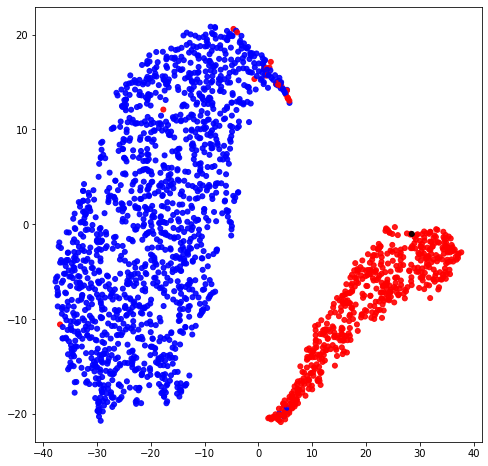

In [19]:
%%time
new_feat_idx = 42

new_embedding = embeddings.transform(feats_sm[new_feat_idx:new_feat_idx+1])
print(new_embedding)
final_embeddings = np.concatenate((embeddings, new_embedding), axis=0)
final_labels = np.concatenate((labels_sm, np.array([2], dtype=np.int32)), axis=0)
plt.figure(figsize=(8,8))
plt.scatter(final_embeddings[:, 0], final_embeddings[:, 1], c=colormap[final_labels], s=25, alpha=0.9);

## Check Model Accuracy

In [20]:
model.compile(metrics=['accuracy'])
model.evaluate(ds_test_xy.batch(512).prefetch(tf.data.AUTOTUNE))

2/2 [==============================] - 7s 615ms/step - loss: 0.0000e+00 - accuracy: 0.9759


[0.0, 0.9759229421615601]

In [21]:
def calc_accuracy(ds):
  preds = []
  labels = []

  for batch_x, batch_y in ds.batch(512):
    print(batch_x.shape, batch_y.shape)
    preds.append(np.argmax(model(batch_x, training=False), axis=1))
    labels.append(np.argmax(batch_y, axis=1))

  preds = np.concatenate(preds)
  labels = np.concatenate(labels)

  acc = tf.keras.metrics.Accuracy()
  acc.update_state(labels, preds)
  return acc.result().numpy()

In [22]:
calc_accuracy(ds_test_xy)

(512, 224, 224, 3) (512, 2)
(111, 224, 224, 3) (111, 2)


0.97592294